<a href="https://colab.research.google.com/github/medsellufbc/BMI/blob/main/OptSEIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 27.5 MB/s 
apm 35.188.240.159_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            5
   Residuals    :            5
 
 Variable time shift OFF
 Number of state variables:           2420
 Number of total equations: -         2310
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            110
 
 **********************************************
 Dynamic Control with Interior Point Solv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


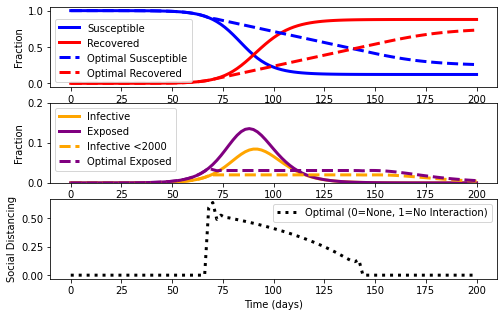

In [2]:
!pip install gekko
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()
u = m.FV(0.1) # social distance (0-1)
        # 0 = no social distancing
        # 0.1 = masks
        # 0.2 = masks and hybrid classes
        # 0.3 = masks, hybrid, and online classes
t_incubation = 5.1
t_infective = 3.3
RO = 2.4
N = 100000 

# initial number of infected and recovered individuals
e_initial = 1/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1-e_initial-i_initial-r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = RO*gamma

m = GEKKO()
u = m.MV(0,lb=0,ub=0.8)

s,e,i,r = m.Array(m.Var,4)
s.value = s_initial
e.value = e_initial
i.value = i_initial
r.value = r_initial
m.Equations([s.dt()==-(1-u)*beta*s*i,\
            e.dt()==(1-u)*beta*s*i-alpha*e,\
            i.dt()==alpha*e-gamma*i,\
            r.dt()==gamma*i])

t = np.linspace(0, 200, 101)
t = np.insert(t,1,[0.001,0.002,0.004,0.008,0.02,0.04,0.08,\
                  0.2,0.4,0.8])
m.time = t

# initialize with simulation
m.options.IMODE=7
m.options.NODES=3
m.solve(disp=False)

# plot the prediction
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue',lw=3, label = 'Susceptible')
plt.plot(m.time, r.value, color='red',lw=3, label = 'Recovered')

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange',lw=3, label = 'Infective')
plt.plot(m.time, e.value, color='purple',lw=3, label = 'Exposed')

# optimize
m.options.IMODE=6
i.UPPER = 0.02
u.STATUS = 1
m.options.SOLVER =3
m.options.TIME_SHIFT = 0
s.value = s.value.value
e.value = e.value.value
i.value = i.value.value
r.value = r.value.value
m.Minimize(u)
m.solve(disp=True)

# plot the optimized response
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue',lw=3, ls='--',label = 'Optimal Susceptible')
plt.plot(m.time, r.value, color='red',lw=3, ls='--',label = 'Optimal Recovered')
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange',lw=3, ls='--',label = 'Infective <2000')
plt.plot(m.time, e.value, color='purple',lw=3, ls='--',label = 'Optimal Exposed')
plt.ylim(0,0.2)
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(m.time, u.value,'k:',lw=3, label = 'Optimal (0=None, 1=No Interaction)')
plt.ylabel('Social Distancing')
plt.legend()

plt.xlabel('Time (days)')

plt.show()